# NEURAL NETWORKS ASSIGNMENT 3 ,part1 hebbian learning

## Import libraries,load data and preprocess it

In [128]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from keras.datasets import cifar10
from sklearn.decomposition import PCA

# Load the Cifar-10 dataset
(X_train_orig, y_train), (X_test_orig, y_test) = cifar10.load_data()



#reshape data for correct input type for the model
X_train = X_train_orig.reshape((-1, 32*32*3)) 
X_test = X_test_orig.reshape((-1, 32*32*3))
#shrink y_train and y_test to one dimension
Y_train=np.ravel(y_train)
Y_test=np.ravel(y_test)




#Normalization
transformer = Normalizer().fit(X_train)  
X_train=transformer.transform(X_train)
transformer = Normalizer().fit(X_test)  
X_test=transformer.transform(X_test)

#Applying PCA function 
pca = PCA(n_components = 64)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Convert labels to one-hot encoded format
# get the transpose 
y_train=keras.utils.to_categorical(Y_train,num_classes=10)
y_test=keras.utils.to_categorical(Y_test,num_classes=10)
x_train=X_train.T
x_test=X_test.T
y_train=y_train.T
y_test=y_test.T

print("Train/test data shape:", x_train.shape, x_test.shape)
print("Train/test labels shape:", y_train.shape, y_test.shape)

Train/test data shape: (64, 50000) (64, 10000)
Train/test labels shape: (10, 50000) (10, 10000)


## Visualization of each class

Class: 0


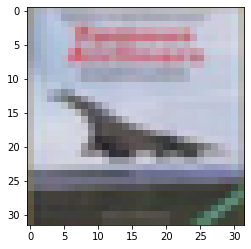

Class: 1


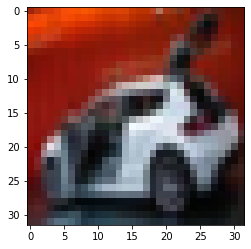

Class: 2


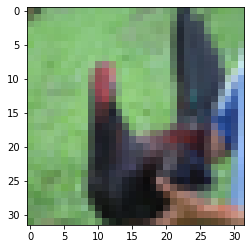

Class: 3


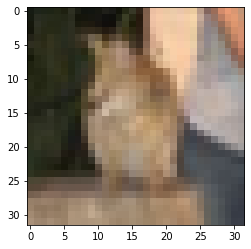

Class: 4


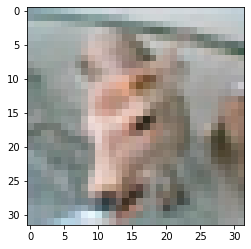

Class: 5


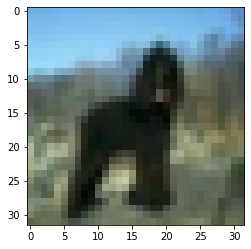

Class: 6


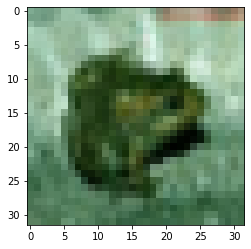

Class: 7


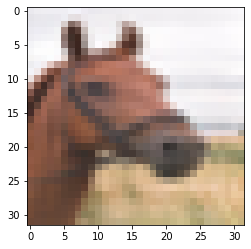

Class: 8


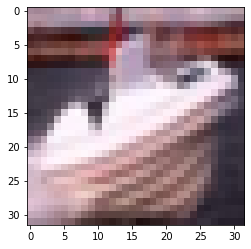

Class: 9


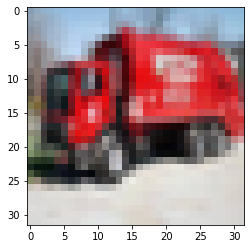

In [129]:
#number of class
i=0
#in the training set find each class and show the image
for j in range(X_train.shape[0]):
    if(Y_test[j]==i):
        print("Class: "+str(i))
        i=i+1
        plt.imshow(X_test_orig[j]) #display sample training image with class i
        plt.show()
    if(i==10):
        break
        

### Initialization of parameters to 0

In [130]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims= array  containing the nodes of each layer of NN
    
    Returns:
    parameters = dictionary containing the parameters "W1", "b1", ..., "WL", "bL":
                    Wl= weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl= bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    # number of layers in NN +1 for layer 0 that is the input
    L = len(layer_dims) 
    for l in range(1, L):
        parameters['W' + str(l)] =np.zeros((layer_dims[l], layer_dims[l-1]))  
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

        
    return parameters

### Activation functions: 

In [131]:
def sigmoid(Z):
    """
    Implements the sigmoid activation 
    
    Arguments:
    Z = Output of the linear layer, of any shape
    
    Returns:
    A = output of sigmoid(z), same shape as Z
    """
    
    A = 1/(1+np.exp(-Z))
    
    return A

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z = Output of the linear layer, of any shape

    Returns:
    A = output of relu(z),same shape as Z
    """
    
    A = np.maximum(0,Z)

    return A

def tanh(Z):
    """
    Implements the tanh activation 
    
    Arguments:
    Z = Output of the linear layer, of any shape
    
    Returns:
    A = output of tanh(z), same shape as Z
    """
    A=np.tanh(Z)

    return A



### Implementation of  forward propagation for a layer

In [132]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Arguments:
    A_prev = activations from previous layer (or input data),numpy array of shape (size of previous layer, number of examples)
    W = weights matrix, numpy array of shape (size of current layer, size of previous layer)
    b = bias vector, numpy array of shape (size of the current layer, 1)
    activation = the activation to be used in this layer, stored as a text string: "sigmoid" or "relu" or "tanh"

    Returns:
    A = the output of the activation function 
    """
    
    if activation == "sigmoid":
        Z =np.dot(W,A_prev)+b
        A=sigmoid(Z)
        
        
    elif activation == "relu":
        Z =np.dot(W,A_prev)+b
        A=relu(Z)

    elif activation == "tanh":
        Z =np.dot(W,A_prev)+b
        A=tanh(Z)


    return A

### Compute cross-entropy cost

In [133]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL = probability vector corresponding to your label predictions, numpy array of shape  (number of clases, number of examples)
    Y = true "label" vector , numpy array of shape (number of classes, number of examples)

    Returns:
    cost = cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute cross-entropy loss from AL and Y.
    #product= element wise multiplacation of -Y and log(AL) arrays ,array of shape (number of classes, number of examples)
    product=-Y*np.log(AL)
    #coste=cost for every example,array of shape (1,number of examples)
    coste=np.sum(product,axis=0)
    #total cost 
    cost=1/m *np.sum(coste)
    
    
    cost = np.squeeze(cost)      # To make sure  cost's shape is what we expect
    
    
    return cost

### Implementation of forward propagation for L-1 layers with activation "activation" and for the last layer with sigmoid activation and Update parameters using Hebbian rule

In [134]:
def L_model_forward_backward_update_parameters(X,Y, params,activation,learning_rate = 0.0075):
    """
    Arguments:
    X = data, numpy array of shape (input size, number of examples)
    params = initialized parameters from initialize_parameters function
    activation=activation function for first L-1 layers stored as a text string: "sigmoid" or "relu" or "tanh"
    learning_rate = learning rate of the hebbian rule
    
    Returns:
    AL = activation value from the output (last) layer,numpy array of shape (output size,number of examples) where output_size=number of classes
    parameters = python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = params.copy()
    A = X
    # number of layers in the NN ,its /2 because we have "W1", "b1", ..., "WL", "bL"
    L = len(parameters) // 2                  
    
    # Implement forward propagation for L-1 layers with activation "activation". Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A 
        A=linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],activation)
        parameters["W"+str(l)]= parameters["W"+str(l)] + learning_rate * np.dot(A,A_prev.T)
        parameters["b"+str(l)]=parameters["b"+str(l)] +learning_rate *   np.sum(A)
    
    # Implement forward propagation for the last  layer with sigmoid activation. Add "cache" to the "caches" list.
    AL=linear_activation_forward(A,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid")
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    # derivative of AL,the output of last layer
    dAL = -np.divide(Y, AL)
    #activation input 
    Z =np.dot(parameters["W"+str(L)],A)+parameters["b"+str(L)]
    #gradient of sigmoid
    s = 1/(1+np.exp(-Z))
    #dZ = Local gradient of the cost with respect to Z for sigmoid
    dZ = dAL * s * (1-s)
    #gradients
    dw=1/m *np.matmul(dZ,A.T)
    db=1/m * np.sum(dZ,axis=1,keepdims=True)
    #parameters update
    parameters["W"+str(L)]= parameters["W"+str(L)] + learning_rate * dw
    parameters["b"+str(L)]=parameters["b"+str(L)] +learning_rate *  db
    
    
    return AL,parameters

### Implementation  of a L-layer NN for classification with L-1 layers with "activation" function and hebbian learning and the last layer with sigmoid activation and gradient descent

In [135]:
def L_layer_model(X, Y, layers_dims,activation, learning_rate = 0.0075, num_iterations = 3000,):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X = data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y = true "label" vector , of shape (number of classes, number of examples)
    layers_dims = list containing the input size and each layer size, of length (number of layers + 1).
    activation= activation function for first L-1 layers stored as a text string: "sigmoid" or "relu" or "tanh"
    learning_rate = learning rate of the hebbian rule
    num_iterations = number of iterations of the optimization loop
    
    Returns:
    parameters = parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)                     
    costs = []
    # Parameters initialization.
    parameters=initialize_parameters(layers_dims)
    
    # Loop (hebbian rule)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> activation]*(L-1) -> LINEAR -> SIGMOID 
        #and update parameters
        AL,parameters=L_model_forward_backward_update_parameters(X,Y,parameters,activation,learning_rate)
        cost=compute_cost(AL, Y)
        #if i % 100 == 0 or i == num_iterations:
        #     print("Iteration {}".format(i))
        if  i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    
    return parameters

In [136]:
#layers_dims = [3072,64, 32, 10] #for cifar10 dataset
layers_dims = [64,32,16, 10] #for cifar10 dataset with pca
activation="sigmoid"
learning_rate = 0.03
parameters = L_layer_model(x_train, y_train,layers_dims,activation,learning_rate, num_iterations = 200)
y_train_pred,params = L_model_forward_backward_update_parameters(x_train,y_train, parameters,activation,learning_rate)
# convert probas to 0-10 prediction
y_train_pred = np.argmax(y_train_pred,axis=0)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(np.argmax(y_train,axis=0), y_train_pred))
y_test_pred,params = L_model_forward_backward_update_parameters(x_test,y_test, parameters,activation,learning_rate)
# convert probas to 0-10 prediction
y_test_pred = np.argmax(y_test_pred,axis=0)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(np.argmax(y_test,axis=0), y_test_pred))

Cost after iteration 0: 0.6931471805599453
Cost after iteration 100: 4.092626236536668
Cost after iteration 199: 9.107602829236212
Accuracy: 0.09996
Accuracy: 0.1


# NEURAL NETWORKS ASSIGNMENT 3 ,part2 RBF network

## Import libraries,load data and preprocess it

In [137]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from keras.datasets import cifar10
from keras import layers
from sklearn.decomposition import PCA

# Load the Cifar-10 dataset
(X_train_orig, y_train), (X_test_orig, y_test) = cifar10.load_data()



#reshape data for correct input type for the model
X_train = X_train_orig.reshape((-1, 32*32*3)) 
X_test = X_test_orig.reshape((-1, 32*32*3))
#shrink y_train and y_test to one dimension
y_train=np.ravel(y_train)
y_test=np.ravel(y_test)


# Convert labels to one-hot encoded format 
Y_train=keras.utils.to_categorical(y_train,num_classes=10)
Y_test=keras.utils.to_categorical(y_test,num_classes=10)


#Normalization
#transformer = Normalizer().fit(X_train)  
#X_train=transformer.transform(X_train)
#transformer = Normalizer().fit(X_test)  
#X_test=transformer.transform(X_test)


print("Train/test data shape:", X_train.shape, X_test.shape)
print("Train/test labels shape:", Y_train.shape, Y_test.shape)

Train/test data shape: (50000, 3072) (10000, 3072)
Train/test labels shape: (50000, 10) (10000, 10)


### Comment:It didn't work well with normalization(too small values)

## Visualization of each class

Class: 0


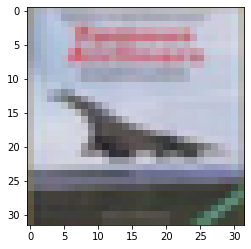

Class: 1


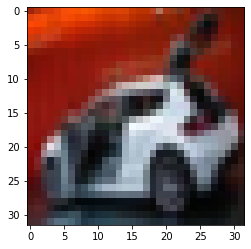

Class: 2


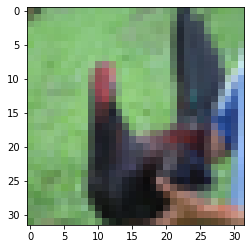

Class: 3


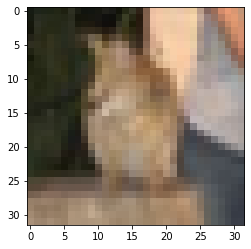

Class: 4


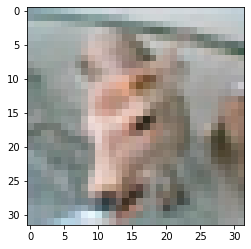

Class: 5


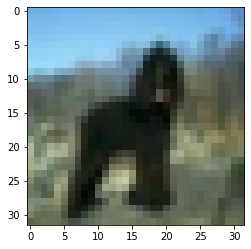

Class: 6


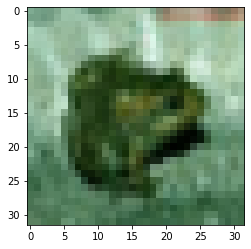

Class: 7


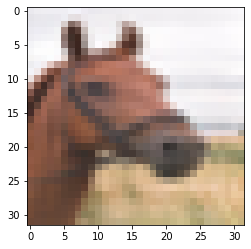

Class: 8


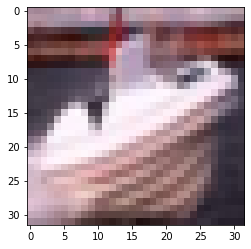

Class: 9


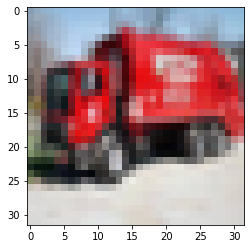

In [5]:
#number of class
i=0
#in the training set find each class and show the image
for j in range(X_train.shape[0]):
    if(y_test[j]==i):
        print("Class: "+str(i))
        i=i+1
        plt.imshow(X_test_orig[j]) #display sample training image with class i
        plt.show()
    if(i==10):
        break
        

## Find centers for each cluster for the hidden level of rbf(about 2,5 hours)

In [109]:
from sklearn.cluster import KMeans

m=4096 #number of clusters or neurons in hidden level
iterations=1000
kmeans=KMeans(n_clusters=m,random_state=0,max_iter=iterations)
kmeans.fit(X_train)
centers=kmeans.cluster_centers_ #cordinates for each center of the claster
print(centers.shape)


(4096, 3072)


## Find max distance between all centers and stds for Gauss function

In [110]:
dMax=np.linalg.norm(centers[1]-centers[2])
for c1 in centers:
    for c2 in centers:
        if np.linalg.norm(c1-c2)>dMax:
            dMax=np.linalg.norm(c1-c2)
        
print(dMax)
stds = dMax / np.sqrt(2*m)
print(stds)

11863.760718677684
131.07727585236842


In [113]:
k=np.exp(-1 / (2 * stds**2) * np.linalg.norm(X_train-centers[0],axis=1))
print(k)

[0.00000000e+000 7.83589075e-299 5.86678688e-274 ... 0.00000000e+000
 2.27638765e-229 7.92220704e-166]


## Calculate ouput for hidden layer with Gauss function for train set(about 1,5 hour)

In [114]:
hidden_output_train=np.exp(-1 / (2 * stds**2) * np.linalg.norm(X_train-centers[0],axis=1)).reshape((-1,1))
for i in range(1,centers.shape[0]):
    hidden_output_train=np.append(hidden_output_train,np.exp(-1 / (2 * stds**2) * np.linalg.norm(X_train-centers[i],axis=1)).reshape((-1,1)),axis=1)
print(hidden_output_train.shape)

(50000, 4096)


## Calculate ouput for hidden layer with Gauss function for test set(20 minutes)

In [115]:
hidden_output_test=np.exp(-1 / (2 * stds**2) * np.linalg.norm(X_test-centers[0],axis=1)).reshape((-1,1))
for i in range(1,centers.shape[0]):
    hidden_output_test=np.append(hidden_output_test,np.exp(-1 / (2 * stds**2) * np.linalg.norm(X_test-centers[i],axis=1)**2).reshape((-1,1)),axis=1)
print(hidden_output_test.shape)

(10000, 4096)


## Pass the output of the hidden layer to one layer NN with softmax activation and train it

In [125]:
model = keras.Sequential()
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(hidden_output_train, Y_train, epochs=500, shuffle=True)
print("Evaluate on train data")
results_train = model.evaluate(hidden_output_train, Y_train)
print("train loss, train acc:", results_train)
print("Evaluate on test data")
results_test = model.evaluate(hidden_output_test, Y_test)
print("test loss, test acc:", results_test)


Epoch 1/500
1563/1563 [==============================] - 4s 2ms/step - loss: 2.5624 - accuracy: 0.1286
Epoch 2/500
1563/1563 [==============================] - 4s 2ms/step - loss: 2.4642 - accuracy: 0.1553
Epoch 3/500
1563/1563 [==============================] - 3s 2ms/step - loss: 2.4576 - accuracy: 0.1625
Epoch 4/500
1563/1563 [==============================] - 3s 2ms/step - loss: 2.3957 - accuracy: 0.1748
Epoch 5/500
1563/1563 [==============================] - 3s 2ms/step - loss: 2.3940 - accuracy: 0.1793
Epoch 6/500
1563/1563 [==============================] - 3s 2ms/step - loss: 2.4084 - accuracy: 0.1847
Epoch 7/500
1563/1563 [==============================] - 3s 2ms/step - loss: 2.3457 - accuracy: 0.1919
Epoch 8/500
1563/1563 [==============================] - 3s 2ms/step - loss: 2.3413 - accuracy: 0.1976
Epoch 9/500
1563/1563 [==============================] - 3s 2ms/step - loss: 2.3603 - accuracy: 0.2003
Epoch 10/500
1563/1563 [==============================] - 3s 2ms/step - l

### Results for different model hyperameters for k=4096 centers in hidden layers


### Results: Adam optimization is better than sgd optimization

## Comparing with KNN and NCC results

### 1)KNN

In [122]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Applying PCA function for n_components=2
#pca = PCA(n_components = 32)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)

#setting how many neighbors to look
neighbors=3
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=neighbors)
#Train the model using the training sets
knn.fit(X_train, y_train)
#Predict for test dataset
y_predk = knn.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predk))

Accuracy: 0.3303


### Accuracy of KNN algorithm for n_components=32 at PCA before the training

### Accuracy of KNN algorithm without PCA before the training

### 1)NCC

In [123]:
from sklearn.neighbors import NearestCentroid

#Create NearestCentroid Classifier
model = NearestCentroid()
#Train the model using the training sets
model.fit(X_train, y_train)
#Predict for test dataset
y_predk=model.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predk))

Accuracy: 0.2774


### Accuracy of NCC algorithm for  n_components=256 at PCA before the training